In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('Chennai.csv')

In [3]:
df.head()

,Season,Climate,City,Building type,Cooling startegy,Age,Sex,Thermal sensation,Thermal sensation acceptability,Thermal preference,Air movement preference,PMV,PPD,Clo,Met,Air temperature (°C),Relative humidity (%),Air velocity (m/s),Outdoor monthly air temperature (°C)
0,Winter,Tropical wet savanna,Chennai,Office,Air Conditioned,NaN,Female,-2.0,1.0,Warmer,no change,0.3,7.0,0.75,1.0,25.2,64.0,0.1,30.8
1,Winter,Tropical wet savanna,Chennai,Office,Air Conditioned,NaN,Male,-1.0,1.0,No Change,no change,0.1,5.0,0.64,1.0,25.2,64.0,0.1,30.8
2,Winter,Tropical wet savanna,Chennai,Office,Air Conditioned,NaN,Male,-2.0,1.0,No Change,no change,0.1,5.0,0.64,1.0,25.2,64.0,0.1,30.8
3,Winter,Tropical wet savanna,Chennai,Office,Air Conditioned,NaN,Female,-2.0,1.0,No Change,less,0.3,7.0,0.75,1.0,25.2,64.0,0.1,30.8
4,Winter,Tropical wet savanna,Chennai,Office,Air Conditioned,NaN,Male,0.0,1.0,Warmer,more,0.2,6.0,0.72,1.0,25.2,64.0,0.1,30.8


In [4]:
df['Season'].value_counts()

Season
Summer    1172
Autumn     871
Winter     869
Spring     719
Name: count, dtype: int64

In [5]:
df.loc[:,['PPD','Thermal sensation acceptability ']].sample(15)

,PPD,Thermal sensation acceptability
3106,24.0,0.0
262,5.0,1.0
2454,7.0,1.0
1495,27.0,1.0
3012,15.0,1.0
3178,5.0,1.0
1861,42.0,1.0
2874,15.0,1.0
1342,12.0,1.0
1780,14.0,1.0


In [6]:
df.drop(columns=['Climate','City','Thermal sensation','Air movement preference', 'Thermal preference','Thermal sensation acceptability ','PMV'],inplace = True)

In [7]:
df['PPD'].describe()

count    3631.000000
mean       22.766731
std        22.516180
min         5.000000
25%         7.000000
50%        14.000000
75%        29.000000
max        99.000000
Name: PPD, dtype: float64

In [8]:
df.columns

Index(['Season', 'Building type', 'Cooling startegy', 'Age', 'Sex', 'PPD',
       'Clo', 'Met', 'Air temperature (°C)', 'Relative humidity (%)',
       'Air velocity (m/s)', 'Outdoor monthly air temperature (°C)'],
      dtype='object')

In [9]:
X = df[['Air temperature (°C)','Relative humidity (%)','Air velocity (m/s)','Clo','Met','Outdoor monthly air temperature (°C)','Season','Building type','Cooling startegy','Sex','Age']]  
y = df['PPD']

In [10]:
# Required packages:
# pip install lightgbm imbalanced-learn scikit-learn seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (accuracy_score, classification_report, precision_recall_curve, 
                             f1_score, recall_score, precision_score, confusion_matrix)
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.combine import SMOTEENN
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore")

In [11]:
# -------------------------
# 1. Train/Test split (keep a hold-out test set)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# 2. Column types
# -------------------------
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# -------------------------
# 3. Preprocessing pipelines
# -------------------------
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
    # you can add scaler if needed: ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')  # drop other columns if any


In [12]:
lgbm_reg = LGBMRegressor(
    subsample=1.0,
    num_leaves=15,
    n_estimators=800,
    min_child_samples=5,
    max_depth=-1,
    learning_rate=0.1,
    colsample_bytree=1.0,
    random_state=42
)

In [13]:
model_pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('clf', lgbm_reg)
])

In [14]:
model_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 2904, number of used features: 16
[LightGBM] [Info] Start training from score 22.622934


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Air temperature (°C)',
                                                   'Relative humidity (%)',
                                                   'Air velocity (m/s)', 'Clo',
                                                   'Met',
                                                   'Outdoor monthly air '
                                                   'temperature (°C)',
                                                   'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Season', 'Building type',
                                                   'Cooling startegy',
                                                   'Sex'])])),
                ('clf',
                 LGBMRegressor(min_child_samples=5, n_estimators=800,
                               num_leaves=15, random_state=42))])

In [15]:
y_pred = model_pipeline.predict(X_test)

In [16]:
# ---------------------------
# Evaluation
# ---------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 4.4776
MAE: 1.7349
R²: 0.9630


In [17]:
# Number of samples and features
n = X_test.shape[0]
p = X_test.shape[1]

# Adjusted R^2
r2_adj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

print(f"Adjusted R²: {r2_adj:.4f}")

Adjusted R²: 0.9624


In [18]:
import pandas as pd

def predict_ppd(model_pipeline, input_data_dict):
    """
    Predicts the PPD (Predicted Percentage of Dissatisfied) for given building and comfort conditions.
    
    Args:
        model_pipeline (Pipeline): Trained regression pipeline with preprocessing (e.g., one-hot encoding).
        input_data_dict (dict): Dictionary mapping feature names (before encoding) to their values.
        
    Returns:
        float: Predicted PPD value (percentage, min 5%).
    """
    # Columns used in training (before preprocessing)
    feature_cols = [
        'Air temperature (°C)', 'Relative humidity (%)', 'Air velocity (m/s)',
        'Clo', 'Met', 'Outdoor monthly air temperature (°C)',
        'Season', 'Building type', 'Cooling startegy', 'Sex', 'Age'
        # 'PMV', 'Thermal sensation acceptability '
    ]
    
    # Create DataFrame from input dictionary
    input_df = pd.DataFrame([input_data_dict])
    
    # Ensure all required columns are present
    missing_cols = set(feature_cols) - set(input_df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Reorder columns
    input_df = input_df[feature_cols]
    
    # Predict using the trained pipeline (which handles encoding/scaling)
    predicted_ppd = model_pipeline.predict(input_df)[0]
    
    # PPD cannot be less than 5% by definition
    return max(5.0, predicted_ppd)


# --- Example Usage ---
example_scenario = {
    'Air temperature (°C)': 27.0,
    'Relative humidity (%)': 50.0,
    'Air velocity (m/s)': 0.1,
    'Clo': 0.5,
    'Met': 1.2,
    'Outdoor monthly air temperature (°C)': 40.0,
    'Season': 'Summer',
    'Building type': 'Office',
    'Cooling startegy': 'Air Conditioned',
    'Sex': 'Male',
    'Age': 35
    # 'PMV': 1,
    # 'Thermal sensation acceptability ': 0
}

predicted_val = predict_ppd(model_pipeline, example_scenario)
print(f"Predicted PPD for example scenario: {predicted_val:.2f}%")


Predicted PPD for example scenario: 20.83%


## Since PMV and Thermal sensation acceptability were causing the model overfits the data and was giving very high Accuracy , This was due to multicollinearity , I was changing Air temperature but PMV also depends upon Air tempertuare . So I have removed those PMV and Thermal Sensation Acceptability column from the model

In [19]:
df['Age'] = df['Age'].fillna(df['Age'].median())

In [20]:
cooling_df = df[df['Outdoor monthly air temperature (°C)'] > df['Air temperature (°C)']].copy()

# Drop rows with missing values in required columns
required_cols = ['Air temperature (°C)', 'Outdoor monthly air temperature (°C)', 'Relative humidity (%)']

In [21]:
# -----------------------------
# 2. Create the physics-inspired proxy target
# -----------------------------
cooling_df['energy_proxy'] = (
    (cooling_df['Outdoor monthly air temperature (°C)'] - cooling_df['Air temperature (°C)']) *
    (1 + cooling_df['Relative humidity (%)'] / 100)
)
# -----------------------------
# 3. Define features & target
# -----------------------------
# We'll use the same numeric + categorical features you used for PPD prediction (but no target leakage)
energy_features_cols = [
    'Air temperature (°C)',
    'Relative humidity (%)',
    'Air velocity (m/s)',
    'Clo',
    'Met',
    'Outdoor monthly air temperature (°C)',
    'Season',
    'Building type',
    'Cooling startegy',
    'Sex',
    'Age'
]

In [22]:
X_energy = cooling_df[energy_features_cols]
y_energy = cooling_df['energy_proxy']

In [23]:
# One-hot encode categorical variables
X_energy = pd.get_dummies(X_energy, drop_first=True)
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(X_energy, y_energy, test_size=0.2, random_state=42)
# -----------------------------
# 5. Train Gradient Boosting Regressor
# -----------------------------
energy_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
energy_model.fit(X_train_en, y_train_en)

GradientBoostingRegressor(random_state=42)

In [24]:
# 6. Evaluate model
# -----------------------------
y_pred_en = energy_model.predict(X_test_en)
print("\n--- Energy Model Evaluation ---")
print("R-squared:", r2_score(y_test_en, y_pred_en))
print("Mean Squared Error:", mean_squared_error(y_test_en, y_pred_en))


--- Energy Model Evaluation ---
R-squared: 0.9991174973735528
Mean Squared Error: 0.034310002555689


In [25]:
# Number of samples and features
n = X_test_en.shape[0]
p = X_test_en.shape[1]
r2 = r2_score(y_test_en, y_pred_en)

# Adjusted R^2
r2_adj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

print(f"Adjusted R²: {r2_adj:.4f}")

Adjusted R²: 0.9991


In [214]:
# -----------------------------
# 7. Energy estimation function
# -----------------------------
def estimate_relative_energy(energy_model, T_indoor, T_outdoor, RH, other_features=None):
    """
    Estimates the relative cooling energy consumption.
    
    Args:
        energy_model: Trained regression model.
        T_indoor (float): Indoor air temperature (°C).
        T_outdoor (float): Outdoor air temperature (°C).
        RH (float): Relative humidity (%).
        other_features (dict): Optional additional features for prediction.
        
    Returns:
        float: Predicted relative energy consumption (>=0).
    """
    if T_indoor >= T_outdoor:
        return 0.0  # No cooling load if it's warmer inside
    
    # Default values for missing features
    defaults = {
        'Air velocity (m/s)': 0.1,
        'Clo': 0.5,
        'Met': 1.2,
        'Season': 'Summer',
        'Building type': 'Office',
        'Cooling startegy': 'Air Conditioned',
        'Sex': 'Female',
        'Age': 30
    }
    
    if other_features:
        defaults.update(other_features)
    
    # Prepare single-row dataframe
    input_dict = {
        'Air temperature (°C)': T_indoor,
        'Relative humidity (%)': RH,
        'Air velocity (m/s)': defaults['Air velocity (m/s)'],
        'Clo': defaults['Clo'],
        'Met': defaults['Met'],
        'Outdoor monthly air temperature (°C)': T_outdoor,
        'Season': defaults['Season'],
        'Building type': defaults['Building type'],
        'Cooling startegy': defaults['Cooling startegy'],
        'Sex': defaults['Sex'],
        'Age': defaults['Age']
    }
    
    input_df = pd.DataFrame([input_dict])
    input_df = pd.get_dummies(input_df, drop_first=True)
    
    # Align columns with training data
    input_df = input_df.reindex(columns=X_energy.columns, fill_value=0)
    
    predicted_energy = energy_model.predict(input_df)[0]
    return max(0.0, predicted_energy)

In [226]:
from pymoo.core.problem import Problem
import numpy as np
# YOU can change Air velocity also , Va - 0.25,
class IndoorClimateProblem(Problem):
    """
    Multi-objective optimization problem for indoor climate control.
    
    Decision variable:
        - Indoor Air Temperature (°C)

    Objectives to minimize:
        1. Predicted Percentage of Dissatisfied (PPD)
        2. Relative Cooling Energy Use
    """
    def __init__(self, model_pipeline, energy_model):
        """
        Initialize the problem.
        
        Args:
            model_pipeline: Trained PPD prediction pipeline.
            energy_model: Trained relative energy prediction model.
        """
        super().__init__(
            n_var=1,          # one decision variable: indoor temp
            n_obj=2,          # PPD and energy
            n_constr=0,       # no constraints
            xl=np.array([20.0]),
            xu=np.array([30.0])
        )
        self.model_pipeline = model_pipeline
        self.energy_model = energy_model

    def _evaluate(self, x, out, *args, **kwargs):
        """
        Vectorized evaluation of the objectives for a given population.
        
        Args:
            x (np.ndarray): Shape (pop_size, 1) — indoor temperatures.
            out (dict): Output dictionary for pymoo.
        """
        ppd_values = []
        energy_values = []

        for temp in x[:, 0]:
            # Prepare scenario with defaults for non-temperature variables
            scenario = {
                'Air temperature (°C)': temp,
                'Relative humidity (%)': 50.0,
                'Air velocity (m/s)': 0.1,
                'Clo': 0.5,
                'Met': 1.2,
                'Outdoor monthly air temperature (°C)': 35.0,
                'Season': 'Summer',
                'Building type': 'Office',
                'Cooling startegy': 'Air Conditioned',
                'Sex': 'Male',
                'Age': 35
            }

            # Predict PPD using existing pipeline
            ppd_val = predict_ppd(self.model_pipeline, scenario)

            # Predict relative energy using existing function
            energy_val = estimate_relative_energy(
                self.energy_model,
                T_indoor=temp,
                T_outdoor=scenario['Outdoor monthly air temperature (°C)'],
                RH=scenario['Relative humidity (%)'],
                other_features=scenario
            )

            ppd_values.append(ppd_val)
            energy_values.append(energy_val)

        # Combine objectives into shape (pop_size, 2)
        out["F"] = np.column_stack([ppd_values, energy_values])


In [227]:
# Replace with your actual trained models
problem = IndoorClimateProblem(model_pipeline, energy_model)

algorithm = NSGA2(pop_size=100)

termination = ('n_gen', 50)

# Run the optimization
res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=True)

# --- Results ---
print("\n--- Optimization Results ---")
print(f"Number of solutions found: {len(res.F)}")

# Extract and sort Pareto front
sorted_solutions = sorted(
    zip(res.X[:, 0], res.F[:, 0], res.F[:, 1]),
    key=lambda row: (row[1], row[2])
)

print("\n--- Sorted Pareto Solutions ---")
print("Indoor_Temp_C  Predicted_PPD  Relative_Energy")
for t, ppd, energy in sorted_solutions:
    print(f"{t:.3f}         {ppd:.3f}         {energy:.3f}")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     35 |             - |             -
     2 |      200 |     73 |  0.0138847396 |         ideal
     3 |      300 |    100 |  0.0003677733 |             f
     4 |      400 |    100 |  0.0033321078 |             f
     5 |      500 |    100 |  0.000000E+00 |             f
     6 |      600 |    100 |  0.0000423463 |             f
     7 |      700 |    100 |  0.0000423463 |             f
     8 |      800 |    100 |  0.0000846926 |             f
     9 |      900 |    100 |  0.0001270388 |             f
    10 |     1000 |    100 |  0.0001270388 |             f
    11 |     1100 |    100 |  0.0001693851 |             f
    12 |     1200 |    100 |  0.0001270388 |             f
    13 |     1300 |    100 |  0.0001270388 |             f
    14 |     1400 |    100 |  0.0001693851 |             f
    15 |     1500 |    100 |  0.0001693851 |             f
    16 |     1600 |    100 |  0.0000846926 |            

In [28]:
sorted_solutions

NameError: name 'sorted_solutions' is not defined

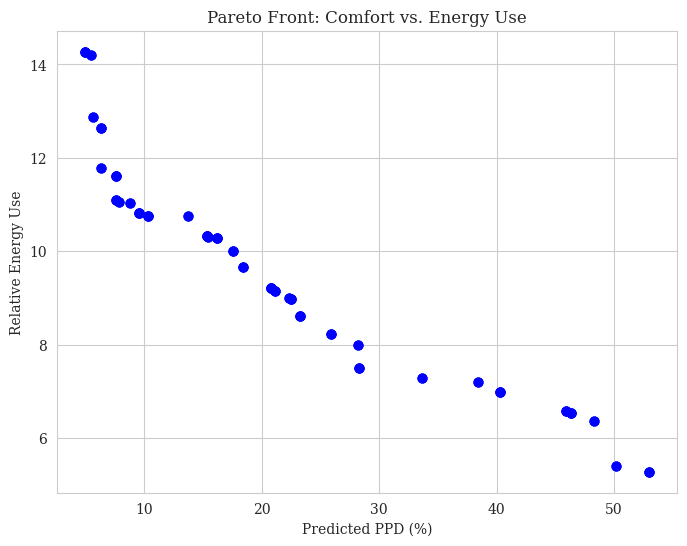

In [228]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt

# --- Extract Pareto front ---
pareto_front = res.F  # Columns: [Predicted_PPD, Relative_Energy]

# --- Create scatter plot ---
plot = Scatter(
    title="Pareto Front: Comfort vs. Energy Use",
    labels=["Predicted PPD (%)", "Relative Energy Use"]
)

# Add Pareto front data (blue points)
plot.add(pareto_front, color="blue", s=40)

# Show plot
plot.show()


In [229]:
import numpy as np

pareto_front = res.F  # Columns: [Predicted_PPD, Relative_Energy]
pareto_vars = res.X   # Corresponding decision variables (e.g., indoor temperature, etc.)

# --- 1. Comfort-Biased Solution (minimum PPD) ---
comfort_biased_idx = np.argmin(pareto_front[:, 0])
comfort_solution = {
    "temperature": pareto_vars[comfort_biased_idx][0],   # Assuming first decision variable is temperature
    "ppd": pareto_front[comfort_biased_idx, 0],
    "energy": pareto_front[comfort_biased_idx, 1]
}

# --- 2. Energy-Biased Solution (minimum Energy) ---
energy_biased_idx = np.argmin(pareto_front[:, 1])
energy_solution = {
    "temperature": pareto_vars[energy_biased_idx][0],
    "ppd": pareto_front[energy_biased_idx, 0],
    "energy": pareto_front[energy_biased_idx, 1]
}

# --- 3. Balanced "Knee" Solution ---
# Normalize objectives for fair comparison
normalized_front = (pareto_front - pareto_front.min(axis=0)) / \
                   (pareto_front.max(axis=0) - pareto_front.min(axis=0))

# Find point closest to origin (0,0)
balanced_idx = np.argmin(np.sqrt(normalized_front[:, 0]**2 + normalized_front[:, 1]**2))
balanced_solution = {
    "temperature": pareto_vars[balanced_idx][0],
    "ppd": pareto_front[balanced_idx, 0],
    "energy": pareto_front[balanced_idx, 1]
}

# --- Print results ---
print("\n--- Key Trade-off Solutions ---")
print(f"Comfort-Biased Solution: Temp={comfort_solution['temperature']:.2f}°C, "
      f"PPD={comfort_solution['ppd']:.2f}%, Energy={comfort_solution['energy']:.2f}")
print(f"Energy-Biased Solution:  Temp={energy_solution['temperature']:.2f}°C, "
      f"PPD={energy_solution['ppd']:.2f}%, Energy={energy_solution['energy']:.2f}")
print(f"Balanced 'Knee' Solution: Temp={balanced_solution['temperature']:.2f}°C, "
      f"PPD={balanced_solution['ppd']:.2f}%, Energy={balanced_solution['energy']:.2f}")



--- Key Trade-off Solutions ---
Comfort-Biased Solution: Temp=23.68°C, PPD=5.00%, Energy=14.27
Energy-Biased Solution:  Temp=29.95°C, PPD=52.95%, Energy=5.28
Balanced 'Knee' Solution: Temp=27.48°C, PPD=23.23%, Energy=8.61



--- Key Trade-off Solutions ---
Comfort-Biased Solution: Temp=23.68°C, PPD=5.00%, Energy=14.27
Energy-Biased Solution:  Temp=29.95°C, PPD=52.95%, Energy=5.28
Balanced 'Knee' Solution: Temp=27.48°C, PPD=23.23%, Energy=8.61


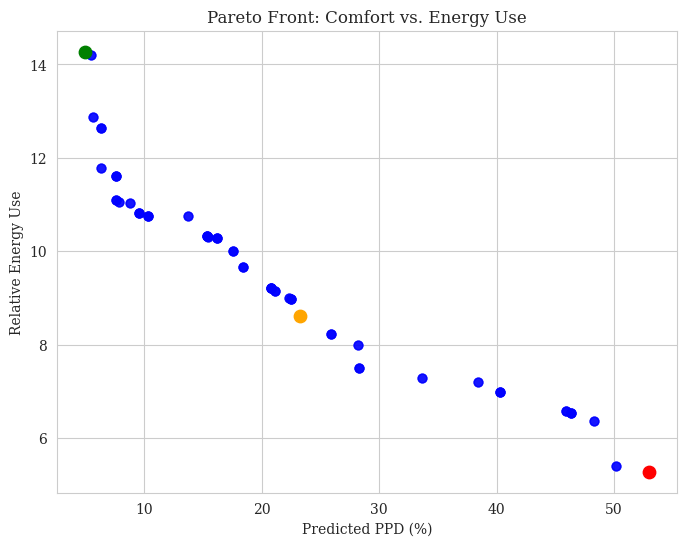

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.visualization.scatter import Scatter

pareto_front = res.F  # Columns: [Predicted_PPD, Relative_Energy]
pareto_vars = res.X   # Corresponding decision variables

# --- 1. Comfort-Biased Solution ---
comfort_biased_idx = np.argmin(pareto_front[:, 0])
comfort_solution = {
    "temperature": pareto_vars[comfort_biased_idx][0],
    "ppd": pareto_front[comfort_biased_idx, 0],
    "energy": pareto_front[comfort_biased_idx, 1]
}

# --- 2. Energy-Biased Solution ---
energy_biased_idx = np.argmin(pareto_front[:, 1])
energy_solution = {
    "temperature": pareto_vars[energy_biased_idx][0],
    "ppd": pareto_front[energy_biased_idx, 0],
    "energy": pareto_front[energy_biased_idx, 1]
}

# --- 3. Balanced "Knee" Solution ---
normalized_front = (pareto_front - pareto_front.min(axis=0)) / \
                   (pareto_front.max(axis=0) - pareto_front.min(axis=0))
balanced_idx = np.argmin(np.sqrt(normalized_front[:, 0]**2 + normalized_front[:, 1]**2))
balanced_solution = {
    "temperature": pareto_vars[balanced_idx][0],
    "ppd": pareto_front[balanced_idx, 0],
    "energy": pareto_front[balanced_idx, 1]
}

# --- Print results ---
print("\n--- Key Trade-off Solutions ---")
print(f"Comfort-Biased Solution: Temp={comfort_solution['temperature']:.2f}°C, "
      f"PPD={comfort_solution['ppd']:.2f}%, Energy={comfort_solution['energy']:.2f}")
print(f"Energy-Biased Solution:  Temp={energy_solution['temperature']:.2f}°C, "
      f"PPD={energy_solution['ppd']:.2f}%, Energy={energy_solution['energy']:.2f}")
print(f"Balanced 'Knee' Solution: Temp={balanced_solution['temperature']:.2f}°C, "
      f"PPD={balanced_solution['ppd']:.2f}%, Energy={balanced_solution['energy']:.2f}")

# --- Visualization ---
plot = Scatter(title="Pareto Front: Comfort vs. Energy Use",
               labels=["Predicted PPD (%)", "Relative Energy Use"])

# Add Pareto front
plot.add(pareto_front, color="blue", alpha=0.7, s=40)

# Highlight the three solutions
plot.add(np.array([[comfort_solution["ppd"], comfort_solution["energy"]]]),
         color="green", s=80, label="Comfort-Biased")
plot.add(np.array([[energy_solution["ppd"], energy_solution["energy"]]]),
         color="red", s=80, label="Energy-Biased")
plot.add(np.array([[balanced_solution["ppd"], balanced_solution["energy"]]]),
         color="orange", s=80, label="Balanced 'Knee'")

# Show the plot
plot.show()


In [231]:
import pandas as pd

# Data provided
data = {
    'Indoor_Temp_C': [
        23.676, 23.656, 23.708, 23.739, 23.887, 23.821, 24.516, 24.506, 24.722, 24.689, 
        24.703, 25.074, 25.137, 25.264, 25.305, 25.254, 25.265, 25.549, 25.515, 25.482, 
        25.690, 25.653, 25.768, 25.752, 25.863, 25.911, 25.911, 25.922, 26.044, 26.031, 
        26.014, 26.027, 26.310, 26.253, 26.357, 26.432, 26.351, 26.436, 26.441, 26.522, 
        26.523, 26.625, 26.641, 26.615, 26.640, 26.842, 26.800, 26.818, 26.934, 26.872, 
        26.852, 26.976, 26.983, 27.045, 27.039, 27.028, 26.974, 27.124, 27.126, 27.074, 
        27.320, 27.264, 27.439, 27.389, 27.425, 27.376, 27.481, 27.539, 27.537, 27.533, 
        27.862, 27.910, 27.941, 28.022, 27.954, 28.196, 28.175, 28.237, 28.324, 28.255, 
        28.508, 28.531, 28.789, 28.788, 28.845, 28.800, 29.093, 29.128, 29.149, 29.208, 
        29.211, 29.193, 29.224, 29.258, 29.343, 29.844, 29.790, 29.950, 29.966, 29.994
    ],
    'Predicted_PPD': [
        5.000, 5.000, 5.000, 5.000, 5.506, 5.506, 5.637, 5.637, 6.336, 6.336, 
        6.336, 6.348, 6.348, 7.651, 7.651, 7.651, 7.651, 7.656, 7.656, 7.656, 
        7.854, 7.854, 8.785, 8.785, 9.593, 9.593, 9.593, 9.593, 10.318, 10.318, 
        10.318, 10.318, 13.705, 13.705, 15.376, 15.376, 15.376, 15.376, 15.376, 
        15.465, 15.465, 16.209, 16.209, 16.209, 16.209, 17.541, 17.541, 17.541, 
        18.392, 18.392, 18.392, 20.830, 20.830, 20.830, 20.830, 20.830, 20.830, 
        21.145, 21.145, 21.145, 22.372, 22.372, 22.513, 22.513, 22.513, 22.513, 
        23.234, 23.234, 23.234, 23.234, 25.883, 25.883, 25.883, 28.195, 28.195, 
        28.272, 28.272, 28.272, 33.679, 33.679, 38.443, 38.443, 40.323, 40.323, 
        40.323, 40.323, 45.870, 45.870, 45.870, 46.364, 46.364, 46.364, 46.364, 
        48.310, 48.310, 50.160, 50.160, 52.954, 52.954, 52.954
    ],
    'Relative_Energy': [
        14.272, 14.272, 14.272, 14.272, 14.207, 14.207, 12.871, 12.871, 12.636, 12.636, 
        12.636, 11.783, 11.783, 11.618, 11.618, 11.618, 11.618, 11.105, 11.105, 11.105, 
        11.064, 11.064, 11.026, 11.026, 10.812, 10.812, 10.812, 10.812, 10.758, 10.758, 
        10.758, 10.758, 10.747, 10.747, 10.323, 10.323, 10.323, 10.323, 10.323, 10.313, 
        10.313, 10.296, 10.296, 10.296, 10.296, 10.016, 10.016, 10.016, 9.655, 9.655, 
        9.655, 9.205, 9.205, 9.205, 9.205, 9.205, 9.205, 9.148, 9.148, 9.148, 9.003, 
        9.003, 8.989, 8.989, 8.989, 8.989, 8.609, 8.609, 8.609, 8.609, 8.224, 8.224, 
        8.224, 7.991, 7.991, 7.495, 7.495, 7.495, 7.298, 7.298, 7.210, 7.210, 6.998, 
        6.998, 6.998, 6.998, 6.575, 6.575, 6.575, 6.551, 6.551, 6.551, 6.551, 6.378, 
        6.378, 5.409, 5.409, 5.284, 5.284, 5.284
    ]
}

# Create DataFrame
results_df = pd.DataFrame(data)

# Save to CSV
results_df.to_csv('Final_Results.csv', index=False)


In [232]:
results_df.head()

,Indoor_Temp_C,Predicted_PPD,Relative_Energy
0,23.676,5.000,14.272
1,23.656,5.000,14.272
2,23.708,5.000,14.272
3,23.739,5.000,14.272
4,23.887,5.506,14.207
